<a href="https://colab.research.google.com/github/ApurvaMayank-iitb/24D0894_IE643_NIFTI/blob/main/Autoencoder_for_code_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 58.6 MB/s eta 0:00:00


In [2]:
import os
import zipfile
import nibabel as nib
import nilearn.image as nimg

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from google.colab import drive
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define the path to your data
data_path = '/content/drive/My Drive/BraTS20_Training_001'




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
NIfTI file: BraTS20_Training_001_t1.nii
Image shape: (240, 240, 155)
Affine: [[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]


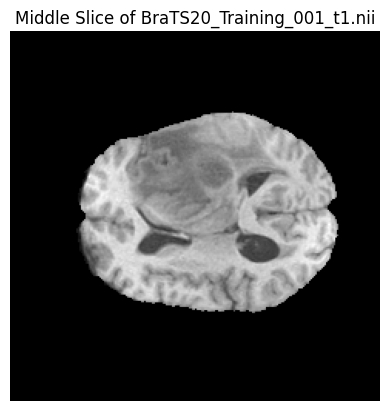

NIfTI file: BraTS20_Training_001_flair.nii
Image shape: (240, 240, 155)
Affine: [[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]


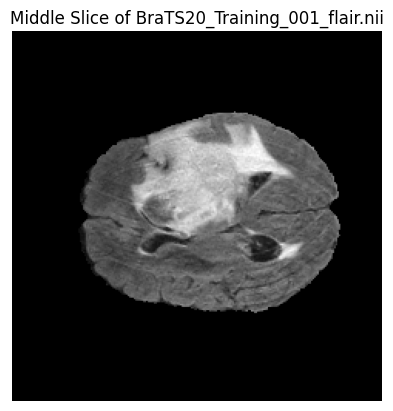

NIfTI file: BraTS20_Training_001_t1ce.nii
Image shape: (240, 240, 155)
Affine: [[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]


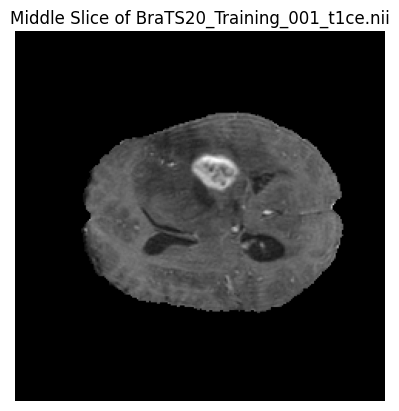

NIfTI file: BraTS20_Training_001_seg.nii
Image shape: (240, 240, 155)
Affine: [[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]


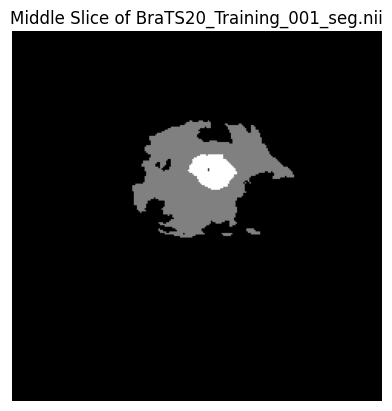

NIfTI file: BraTS20_Training_001_t2.nii
Image shape: (240, 240, 155)
Affine: [[ -1.  -0.  -0.   0.]
 [ -0.  -1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]


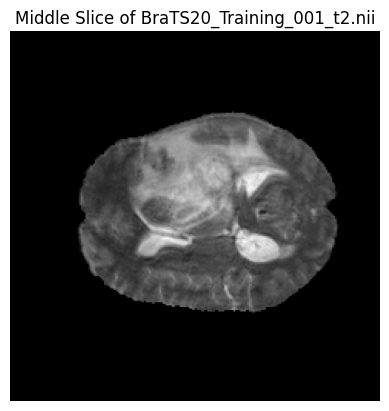

In [12]:
from google.colab import drive
import os
import nibabel as nib
import matplotlib.pyplot as plt

# Step 1: Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Step 2: Set the directory path to the NIfTI files
nifti_dir = '/content/drive/My Drive/my_mri_project/BraTS20_Training_001'

# Load NIfTI files from the specified directory
nii_files = [f for f in os.listdir(nifti_dir) if f.endswith('.nii') or f.endswith('.nii.gz')]

if not nii_files:
    print("No NIfTI files found in the specified directory.")
else:
    for nii_file in nii_files:
        nii_file_path = os.path.join(nifti_dir, nii_file)

        # Load the NIfTI file
        try:
            nifti_image = nib.load(nii_file_path)
            print(f"NIfTI file: {nii_file}")
            print(f"Image shape: {nifti_image.shape}")
            print(f"Affine: {nifti_image.affine}")

            # Display the middle slice of the 3D image
            data = nifti_image.get_fdata()
            if data.ndim < 3:
                print(f"Warning: {nii_file} does not have enough dimensions to display a slice.")
                continue

            slice_index = data.shape[2] // 2  # Get the middle slice
            plt.figure()
            plt.imshow(data[:, :, slice_index], cmap='gray')
            plt.title(f'Middle Slice of {nii_file}')
            plt.axis('off')
            plt.show()

        except FileNotFoundError:
            print(f"File not found: {nii_file_path}")
        except Exception as e:
            print(f"An error occurred: {e}")


The Brain Tumor Segmentation (BraTS) 2020 dataset is a collection of multimodal Magnetic Resonance Imaging (MRI) scans used for the segmentation of brain tumors.

It includes MRI scans from glioma patients, providing four different MRI modalities (means 4 channels of information - 4 different volumes of the same region) per patient:

Native (T1) Post-contrast T1-weighted (T1ce - contrast enhanced) T2-weighted (T2) T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery)

These scans come with expert-annotated segmentation masks that delineate the tumor into various sub-regions, such as the necrotic and non-enhancing tumor core, the peritumoral edema, and the enhancing tumor.

Annotations (labels):

Label 0: Not Tumor (NT) volume Label 1: Necrotic and non-enhancing tumor core (NCR/NET) Label 2: Peritumoral edema (ED) Label 3: Missing (No pixels in all the volumes contain label 3) Label 4: GD-enhancing tumor (ET)

However since our project is on Unsupervised learning we will not be using the segmented data. We will only take training data without label

In [13]:
import os

def preprocess_patient_data(nifti_dir, save_path, target_shape=(256, 256)):
    # Check and delete the segmentation file if it exists
    seg_file = os.path.join(nifti_dir, 'BraTS20_Training_001_seg.nii')
    if os.path.exists(seg_file):
        os.remove(seg_file)
        print(f"Removed segmentation file: {seg_file}")

    # Define the modalities to be loaded (excluding the segmentation file)
    modalities = ['t1', 't1ce', 't2', 'flair']
    modality_files = {mod: os.path.join(nifti_dir, f'BraTS20_Training_001_{mod}.nii') for mod in modalities}

    # Load and average modalities
    volumes = []
    for mod, file_path in modality_files.items():
        nii_img = nib.load(file_path)
        volumes.append(nii_img.get_fdata())
    averaged_volume = np.mean(volumes, axis=0)

    # Find the best slice (slice with the maximum non-zero pixels)
    slice_sums = np.sum(averaged_volume, axis=(0, 1))
    best_slice_index = np.argmax(slice_sums)

    # Extract the best slice and normalize
    best_slice = averaged_volume[:, :, best_slice_index]
    best_slice = (best_slice - np.min(best_slice)) / (np.max(best_slice) - np.min(best_slice))

    # Resize to target shape
    best_slice_resized = resize(best_slice, target_shape, mode='constant', anti_aliasing=True)

    # Save the preprocessed slice as an .npy file
    np.save(save_path, best_slice_resized)
    print(f"Processed data saved to {save_path}")

    # Optionally, display the processed slice
    plt.imshow(best_slice_resized, cmap='gray')
    plt.title("Best Slice (Processed)")
    plt.axis('off')
    plt.show()

# Example usage
preprocess_patient_data(
    nifti_dir='/content/drive/My Drive/my_mri_project/BraTS20_Training_001',
    save_path='/content/drive/My Drive/my_mri_project/processed_patient_data.npy'
)


Removed segmentation file: /content/drive/My Drive/my_mri_project/BraTS20_Training_001/BraTS20_Training_001_seg.nii


NameError: name 'resize' is not defined

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processed data saved to /content/drive/My Drive/my_mri_project/processed_patient_data.npy


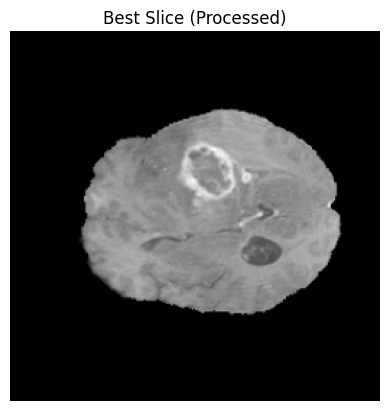

In [14]:
from google.colab import drive
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize  # Import added here

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

def preprocess_patient_data(nifti_dir, save_path, target_shape=(256, 256)):
    # Check and delete the segmentation file if it exists
    seg_file = os.path.join(nifti_dir, 'BraTS20_Training_001_seg.nii')
    if os.path.exists(seg_file):
        os.remove(seg_file)
        print(f"Removed segmentation file: {seg_file}")

    # Define the modalities to be loaded (excluding the segmentation file)
    modalities = ['t1', 't1ce', 't2', 'flair']
    modality_files = {mod: os.path.join(nifti_dir, f'BraTS20_Training_001_{mod}.nii') for mod in modalities}

    # Load and average modalities
    volumes = []
    for mod, file_path in modality_files.items():
        nii_img = nib.load(file_path)
        volumes.append(nii_img.get_fdata())
    averaged_volume = np.mean(volumes, axis=0)

    # Find the best slice (slice with the maximum non-zero pixels)
    slice_sums = np.sum(averaged_volume, axis=(0, 1))
    best_slice_index = np.argmax(slice_sums)

    # Extract the best slice and normalize
    best_slice = averaged_volume[:, :, best_slice_index]
    best_slice = (best_slice - np.min(best_slice)) / (np.max(best_slice) - np.min(best_slice))

    # Resize to target shape
    best_slice_resized = resize(best_slice, target_shape, mode='constant', anti_aliasing=True)

    # Save the preprocessed slice as an .npy file
    np.save(save_path, best_slice_resized)
    print(f"Processed data saved to {save_path}")

    # Optionally, display the processed slice
    plt.imshow(best_slice_resized, cmap='gray')
    plt.title("Best Slice (Processed)")
    plt.axis('off')
    plt.show()

# Example usage
preprocess_patient_data(
    nifti_dir='/content/drive/My Drive/my_mri_project/BraTS20_Training_001',
    save_path='/content/drive/My Drive/my_mri_project/processed_patient_data.npy'
)


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: 32 x 128 x 128
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # Output: 64 x 64 x 64
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # Output: 128 x 32 x 32
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # Output: 256 x 16 x 16
            nn.ReLU(True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: 128 x 32 x 32
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: 64 x 64 x 64
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 32 x 128 x 128
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # Output: 1 x 256 x 256
            nn.Sigmoid()  # Output scaled to [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model
model = ConvAutoencoder()
print(model)


ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
 

In [16]:
# Import necessary libraries
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms
from PIL import Image

# Custom Dataset Class without Augmentation
class MRIDataset(Dataset):
    def __init__(self, npy_file, transform=None):
        self.data = np.load(npy_file)  # Load the .npy file
        self.transform = transform

    def __len__(self):
        return 1  # Single image dataset

    def __getitem__(self, idx):
        image = Image.fromarray((self.data * 255).astype(np.uint8))
        if self.transform:
            image = self.transform(image)
        image = transforms.ToTensor()(image)  # Convert to tensor
        return image

# Define basic transformations without augmentation
data_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch tensor
])

# Dataset and DataLoader setup
npy_file_path = '/content/drive/My Drive/my_mri_project/processed_patient_data.npy'
mri_dataset = MRIDataset(npy_file=npy_file_path, transform=data_transform)
dataloader = DataLoader(mri_dataset, batch_size=1, shuffle=False)

# Check an example batch
for batch in dataloader:
    print("Batch shape:", batch.shape)  # Should be [1, 1, 256, 256]
    break


TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [17]:
# Custom Dataset Class without Augmentation
class MRIDataset(Dataset):
    def __init__(self, npy_file, transform=None):
        self.data = np.load(npy_file)  # Load the .npy file
        self.transform = transform

    def __len__(self):
        return 1  # Single image dataset

    def __getitem__(self, idx):
        image = Image.fromarray((self.data * 255).astype(np.uint8))  # Convert numpy array to PIL Image
        if self.transform:
            image = self.transform(image)  # Apply transformations, including ToTensor() from data_transform
        return image

# Define basic transformations without augmentation
data_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch tensor
])

# Dataset and DataLoader setup
npy_file_path = '/content/drive/My Drive/my_mri_project/processed_patient_data.npy'
mri_dataset = MRIDataset(npy_file=npy_file_path, transform=data_transform)
dataloader = DataLoader(mri_dataset, batch_size=1, shuffle=False)

# Check an example batch
for batch in dataloader:
    print("Batch shape:", batch.shape)  # Should be [1, 1, 256, 256]
    break


Batch shape: torch.Size([1, 1, 256, 256])


In [18]:
import torch
import torch.optim as optim
import torch.nn as nn

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training parameters
num_epochs = 20  # Adjust epochs based on dataset and resources

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for data in dataloader:
        # Move data to device
        inputs = data.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)  # Reconstruction loss

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss for monitoring
        running_loss += loss.item()

    # Calculate and print average loss for the epoch
    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Optional: Save model checkpoint at the end of each epoch
    torch.save(model.state_dict(), f"autoencoder_epoch_{epoch+1}.pth")
    print(f"Model checkpoint saved for epoch {epoch+1}")

print("Training completed.")


Epoch [1/20], Loss: 0.1503
Model checkpoint saved for epoch 1
Epoch [2/20], Loss: 0.1491
Model checkpoint saved for epoch 2
Epoch [3/20], Loss: 0.1477
Model checkpoint saved for epoch 3
Epoch [4/20], Loss: 0.1454
Model checkpoint saved for epoch 4
Epoch [5/20], Loss: 0.1414
Model checkpoint saved for epoch 5
Epoch [6/20], Loss: 0.1339
Model checkpoint saved for epoch 6
Epoch [7/20], Loss: 0.1205
Model checkpoint saved for epoch 7
Epoch [8/20], Loss: 0.1023
Model checkpoint saved for epoch 8
Epoch [9/20], Loss: 0.0884
Model checkpoint saved for epoch 9
Epoch [10/20], Loss: 0.0755
Model checkpoint saved for epoch 10
Epoch [11/20], Loss: 0.0565
Model checkpoint saved for epoch 11
Epoch [12/20], Loss: 0.0415
Model checkpoint saved for epoch 12
Epoch [13/20], Loss: 0.0308
Model checkpoint saved for epoch 13
Epoch [14/20], Loss: 0.0248
Model checkpoint saved for epoch 14
Epoch [15/20], Loss: 0.0224
Model checkpoint saved for epoch 15
Epoch [16/20], Loss: 0.0214
Model checkpoint saved for epo

In [20]:
torch.save(model.state_dict(), "autoencoder_epoch_20.pth")


In [21]:
model = ConvAutoencoder()
model.load_state_dict(torch.load("autoencoder_epoch_20.pth"))
model.eval()  # Set model to evaluation mode


<ipython-input-21-d9cbf48318c9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("autoencoder_epoch_20.pth"))


ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
 

In [22]:
import torch
import torch.nn as nn
import numpy as np
import nibabel as nib
from skimage.transform import resize
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image

# Define the threshold for anomaly detection
RECONSTRUCTION_THRESHOLD = 0.05  # Adjust this threshold based on experiment

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)
model.load_state_dict(torch.load("autoencoder_epoch_20.pth"))
model.eval()  # Set model to evaluation mode

# Step 1: Prompt user to upload files
uploaded_files = files.upload()

# Step 2: Preprocess the uploaded files
def preprocess_uploaded_files(uploaded_files, target_shape=(256, 256)):
    # Define the modalities we expect
    modalities = ['t1', 't1ce', 't2', 'flair']
    modality_data = []

    # Load each modality, assuming filenames contain the modality name
    for mod in modalities:
        for filename in uploaded_files.keys():
            if mod in filename.lower():
                nii_img = nib.load(filename)
                modality_data.append(nii_img.get_fdata())
                break

    if len(modality_data) != 4:
        raise ValueError("All four modalities (T1, T1ce, T2, FLAIR) were not uploaded.")

    # Average the modalities
    averaged_volume = np.mean(modality_data, axis=0)

    # Find the best slice with the maximum non-zero pixels
    slice_sums = np.sum(averaged_volume, axis=(0, 1))
    best_slice_index = np.argmax(slice_sums)
    best_slice = averaged_volume[:, :, best_slice_index]

    # Normalize the slice
    best_slice = (best_slice - np.min(best_slice)) / (np.max(best_slice) - np.min(best_slice))

    # Resize to target shape
    best_slice_resized = resize(best_slice, target_shape, mode='constant', anti_aliasing=True)

    # Convert to PyTorch tensor format and add necessary dimensions for model input
    best_slice_tensor = torch.tensor(best_slice_resized).float().unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 256, 256]
    return best_slice_tensor, best_slice_resized

input_tensor, input_image = preprocess_uploaded_files(uploaded_files)
input_tensor = input_tensor.to(device)

# Step 3: Run the model and calculate reconstruction error
with torch.no_grad():
    reconstructed_tensor = model(input_tensor)
    mse_loss = nn.MSELoss()(reconstructed_tensor, input_tensor)
    reconstruction_error = mse_loss.item()

# Convert reconstructed tensor back to image format for plotting
reconstructed_image = reconstructed_tensor.squeeze().cpu().numpy()

# Step 4: Display results
print(f"Reconstruction error: {reconstruction_error:.4f}")

# Determine anomaly based on threshold
if reconstruction_error > RECONSTRUCTION_THRESHOLD:
    anomaly_message = "Anomaly Detected"
else:
    anomaly_message = "No Anomaly Detected"

# Plot the input and reconstructed images
plt.figure(figsize=(12, 6))

# Original input image
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title("Input Image")
plt.axis("off")

# Reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title(f"Reconstructed Image\n{anomaly_message}")
plt.axis("off")

plt.suptitle(f"Reconstruction Error: {reconstruction_error:.4f}")
plt.show()


<ipython-input-22-6a786f30f152>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("autoencoder_epoch_20.pth"))


Saving BraTS20_Validation_002_t1ce.nii to BraTS20_Validation_002_t1ce.nii
Saving BraTS20_Validation_002_t2.nii to BraTS20_Validation_002_t2.nii


ValueError: All four modalities (T1, T1ce, T2, FLAIR) were not uploaded.

<ipython-input-23-3be7a12b7f97>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("autoencoder_epoch_20.pth"))  # Load weights only


Saving BraTS20_Validation_002_t1ce.nii to BraTS20_Validation_002_t1ce (1).nii
Saving BraTS20_Validation_002_t2.nii to BraTS20_Validation_002_t2 (1).nii
Loaded modality: t1
Loaded modality: t1ce
Loaded modality: t2
Reconstruction error: 0.0084


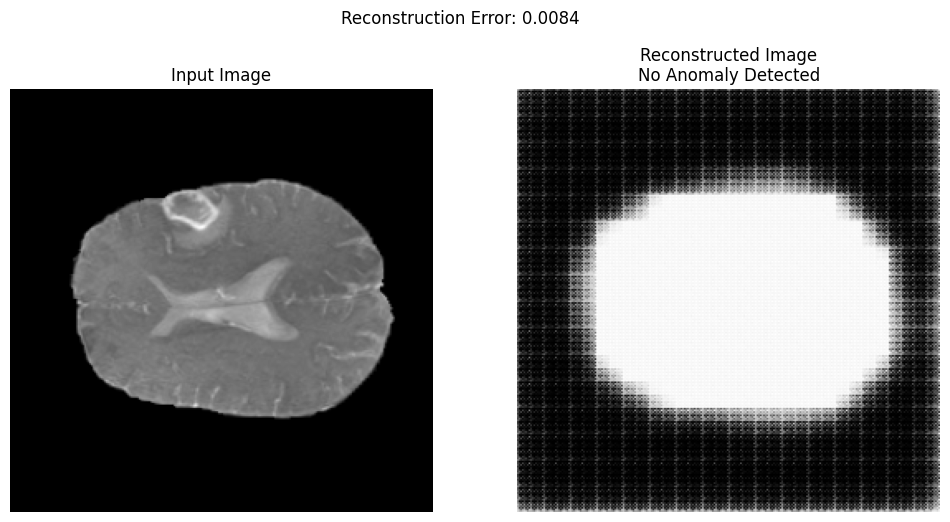

In [23]:
import torch
import torch.nn as nn
import numpy as np
import nibabel as nib
from skimage.transform import resize
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image

# Define the threshold for anomaly detection
RECONSTRUCTION_THRESHOLD = 0.05  # Adjust this threshold based on experiment

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)
model.load_state_dict(torch.load("autoencoder_epoch_20.pth"))  # Load weights only
model.eval()  # Set model to evaluation mode

# Step 1: Prompt user to upload files
uploaded_files = files.upload()

# Step 2: Preprocess the uploaded files
def preprocess_uploaded_files(uploaded_files, target_shape=(256, 256)):
    # Define the expected modalities
    modalities = ['t1', 't1ce', 't2', 'flair']
    modality_data = []

    # Load only the available modalities
    for mod in modalities:
        for filename in uploaded_files.keys():
            if mod in filename.lower():
                nii_img = nib.load(filename)
                modality_data.append(nii_img.get_fdata())
                print(f"Loaded modality: {mod}")
                break

    if len(modality_data) == 0:
        raise ValueError("No valid modalities were uploaded. Please upload at least one modality.")

    # Average the available modalities
    averaged_volume = np.mean(modality_data, axis=0)

    # Find the best slice with the maximum non-zero pixels
    slice_sums = np.sum(averaged_volume, axis=(0, 1))
    best_slice_index = np.argmax(slice_sums)
    best_slice = averaged_volume[:, :, best_slice_index]

    # Normalize the slice
    best_slice = (best_slice - np.min(best_slice)) / (np.max(best_slice) - np.min(best_slice))

    # Resize to target shape
    best_slice_resized = resize(best_slice, target_shape, mode='constant', anti_aliasing=True)

    # Convert to PyTorch tensor format and add necessary dimensions for model input
    best_slice_tensor = torch.tensor(best_slice_resized).float().unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 256, 256]
    return best_slice_tensor, best_slice_resized

input_tensor, input_image = preprocess_uploaded_files(uploaded_files)
input_tensor = input_tensor.to(device)

# Step 3: Run the model and calculate reconstruction error
with torch.no_grad():
    reconstructed_tensor = model(input_tensor)
    mse_loss = nn.MSELoss()(reconstructed_tensor, input_tensor)
    reconstruction_error = mse_loss.item()

# Convert reconstructed tensor back to image format for plotting
reconstructed_image = reconstructed_tensor.squeeze().cpu().numpy()

# Step 4: Display results
print(f"Reconstruction error: {reconstruction_error:.4f}")

# Determine anomaly based on threshold
if reconstruction_error > RECONSTRUCTION_THRESHOLD:
    anomaly_message = "Anomaly Detected"
else:
    anomaly_message = "No Anomaly Detected"

# Plot the input and reconstructed images
plt.figure(figsize=(12, 6))

# Original input image
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title("Input Image")
plt.axis("off")

# Reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title(f"Reconstructed Image\n{anomaly_message}")
plt.axis("off")

plt.suptitle(f"Reconstruction Error: {reconstruction_error:.4f}")
plt.show()


In [24]:
from google.colab import files

# Prompt user to upload files
uploaded_files = files.upload()

# Save file paths in a dictionary for easier access later
file_paths = {filename: filename for filename in uploaded_files.keys()}
print("Files uploaded and stored:", file_paths)


Saving BraTS20_Validation_002_flair.nii to BraTS20_Validation_002_flair.nii
Saving BraTS20_Validation_002_t1.nii to BraTS20_Validation_002_t1.nii
Saving BraTS20_Validation_002_t1ce.nii to BraTS20_Validation_002_t1ce (2).nii
Saving BraTS20_Validation_002_t2.nii to BraTS20_Validation_002_t2 (2).nii
Files uploaded and stored: {'BraTS20_Validation_002_flair.nii': 'BraTS20_Validation_002_flair.nii', 'BraTS20_Validation_002_t1.nii': 'BraTS20_Validation_002_t1.nii', 'BraTS20_Validation_002_t1ce (2).nii': 'BraTS20_Validation_002_t1ce (2).nii', 'BraTS20_Validation_002_t2 (2).nii': 'BraTS20_Validation_002_t2 (2).nii'}


<ipython-input-25-90f92d2810be>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("autoencoder_epoch_20.pth"))  # Load weights only


Loaded modality: t1
Loaded modality: t1ce
Loaded modality: t2
Loaded modality: flair
Reconstruction error: 0.0107 - No Anomaly Detected


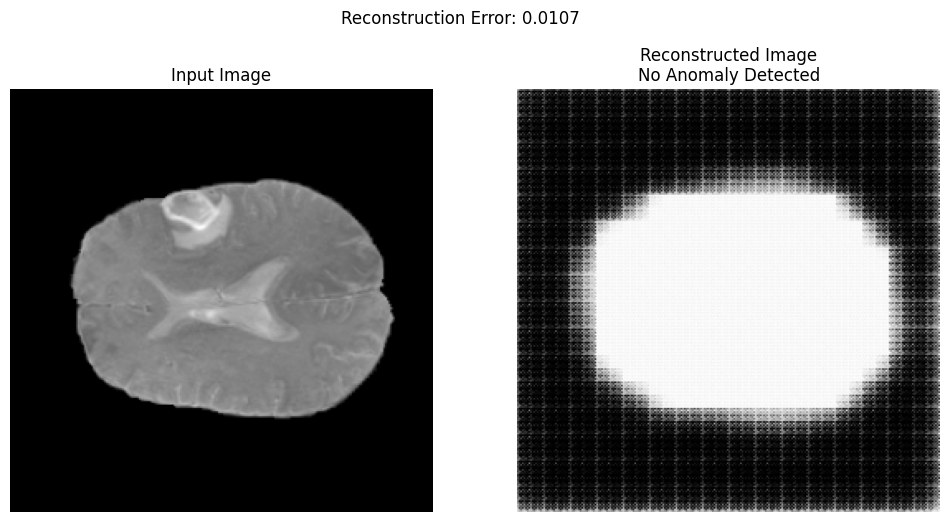

In [25]:
import torch
import torch.nn as nn
import numpy as np
import nibabel as nib
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)
model.load_state_dict(torch.load("autoencoder_epoch_20.pth"))  # Load weights only
model.eval()  # Set model to evaluation mode

# Define the preprocessing function
def preprocess_files(file_paths, target_shape=(256, 256)):
    # Define the expected modalities
    modalities = ['t1', 't1ce', 't2', 'flair']
    modality_data = []

    # Load available modalities
    for mod in modalities:
        for filename in file_paths.keys():
            if mod in filename.lower():
                nii_img = nib.load(file_paths[filename])
                modality_data.append(nii_img.get_fdata())
                print(f"Loaded modality: {mod}")
                break

    if len(modality_data) == 0:
        raise ValueError("No valid modalities were found. Please upload at least one modality.")

    # Average the available modalities
    averaged_volume = np.mean(modality_data, axis=0)

    # Find the best slice with the maximum non-zero pixels
    slice_sums = np.sum(averaged_volume, axis=(0, 1))
    best_slice_index = np.argmax(slice_sums)
    best_slice = averaged_volume[:, :, best_slice_index]

    # Normalize the slice
    best_slice = (best_slice - np.min(best_slice)) / (np.max(best_slice) - np.min(best_slice))

    # Resize to target shape
    best_slice_resized = resize(best_slice, target_shape, mode='constant', anti_aliasing=True)

    # Convert to PyTorch tensor format and add necessary dimensions for model input
    best_slice_tensor = torch.tensor(best_slice_resized).float().unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 256, 256]
    return best_slice_tensor, best_slice_resized

# Define the function to test with different thresholds
def test_anomaly_detection(file_paths, threshold=0.02):
    input_tensor, input_image = preprocess_files(file_paths)
    input_tensor = input_tensor.to(device)

    # Run the model and calculate reconstruction error
    with torch.no_grad():
        reconstructed_tensor = model(input_tensor)
        mse_loss = nn.MSELoss()(reconstructed_tensor, input_tensor)
        reconstruction_error = mse_loss.item()

    # Convert reconstructed tensor back to image format for plotting
    reconstructed_image = reconstructed_tensor.squeeze().cpu().numpy()

    # Determine anomaly based on threshold
    anomaly_message = "Anomaly Detected" if reconstruction_error > threshold else "No Anomaly Detected"
    print(f"Reconstruction error: {reconstruction_error:.4f} - {anomaly_message}")

    # Plot the input and reconstructed images
    plt.figure(figsize=(12, 6))

    # Original input image
    plt.subplot(1, 2, 1)
    plt.imshow(input_image, cmap='gray')
    plt.title("Input Image")
    plt.axis("off")

    # Reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title(f"Reconstructed Image\n{anomaly_message}")
    plt.axis("off")

    plt.suptitle(f"Reconstruction Error: {reconstruction_error:.4f}")
    plt.show()

# Example usage with recommended threshold
test_anomaly_detection(file_paths, threshold=0.02)
